# Examining Concepts from Blockchain Patents

From over a 1000 blockchain related patents over the last 5 years, we are applying structured extraction techniques to identify common themes in these patents and concepts arising from keyword and nounidentification methods.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import re

In [3]:
root_folder='/content/drive/My Drive/DataAnalysis'

In [4]:
data = pd.read_csv(root_folder+'/PatentBlockchain.csv')
data['patent_date'] = pd.Series(pd.to_datetime(data['patent_date'], format='%d/%m/%Y'))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1642 entries, 0 to 1641
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   patent_abstract  1642 non-null   object        
 1   patent_date      1642 non-null   datetime64[ns]
 2   patent_number    1642 non-null   int64         
 3   patent_title     1642 non-null   object        
 4   patent_year      1642 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 64.3+ KB


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [6]:
import warnings
warnings.simplefilter("ignore", FutureWarning)

We see that blockchain patents have grown a low base over the last 5 years, one thing to keep in mind as we analyse the semantics of patents is that there is obviously a lot higher frequency of mentions of any keywords in general. So we have to consider an average over certain time periods.

Text(0.5, 1.0, 'Blockchain Patents over Time')

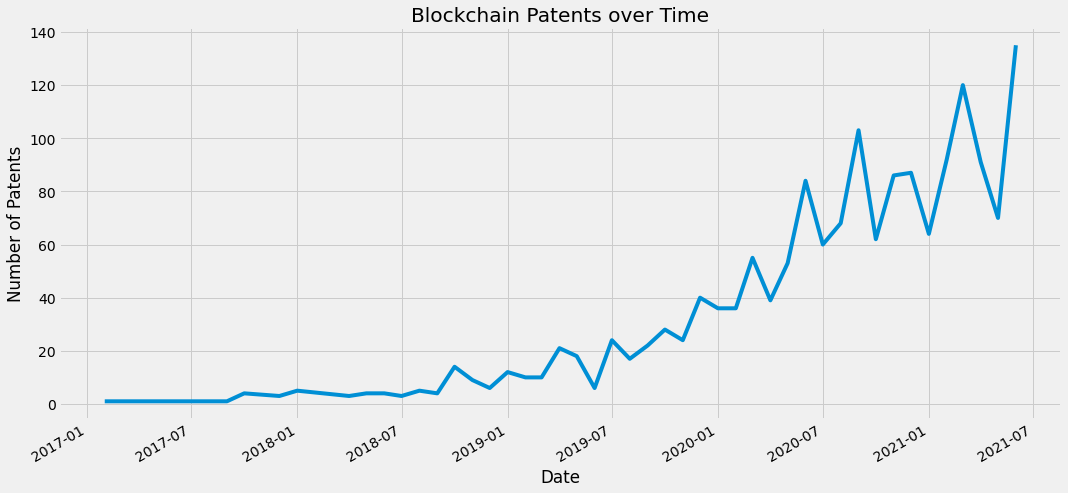

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')

data['year-month'] = [
    pd.datetime(year, month, 1) for year, month in zip(
        data['patent_date'].dt.year, data['patent_date'].dt.month)]

month_group = data.groupby('year-month')['patent_number'].count().reset_index()

month_group.set_index('year-month')['patent_number'].plot(figsize=(16, 8))
plt.ylabel('Number of Patents')
plt.xlabel('Date')
plt.title('Blockchain Patents over Time')

In [ ]:
month_group.groupby(month_group['year-month'].dt.year)['patent_number'].sum().plot.bar(
    color='red', edgecolor='k', figsize=(12, 6))
plt.xlabel('Year')
plt.ylabel('Number of Patents')
plt.title('Neural Network Patents by Year')

# Keyword Analysis and Extraction

Initial data cleaning and analysis then application of TF-IDF (term frequency-inverse document frequency) which is a statistical measure that evaluates how relevant a word is to a document and also Spacy part-of-speech noun identification.

In [8]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [9]:
stopwords = nltk.corpus.stopwords.words('english')

In [10]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

Logical to maintain **two data cleaners** with opposing levels of granularity - one will clean the text of short-words, stop-words and any punctuations, which is useful for embedding due to a reduced vocabulary and for looking at words without considering part of speech. The light cleaner is therefore to preserve grammar / PoS and the structure of sentences to identify nouns, adjectives, etc. 

In [11]:
def text_cleaner(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)
    newString = re.sub('[^a-zA-Z\s\-]', '', newString)
    newString = re.sub('[^a-zA-Z\s]', ' ', newString)
    tokens = [w for w in newString.split() if w not in stopwords]
    long_words = []
    prev_word = []
    for i in tokens:
        if i not in prev_word and len(i) >= 3:  # removing short word
            long_words.append(i)
            prev_word = [i]
    return (" ".join(long_words)).strip()

In [12]:
def text_cleaner_light(text):
    newString = text.lower()
    newString = re.sub('"', '', newString)
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(' ')])
    newString = re.sub(r"’s\b", "", newString)

    return newString

In [ ]:
def plot_wordcloud(year):
    per_year = data[data['patent_year'] == year]
    cleaned_text = per_year['patent_abstract'].apply(lambda x : text_cleaner(x))
    long_string = ','.join(list(cleaned_text.values))
    
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
    wordcloud.generate(long_string)
    return wordcloud.to_image()

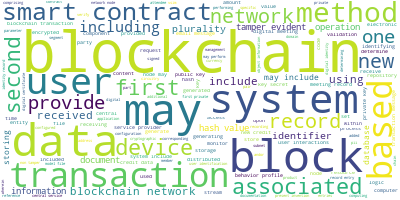

In [ ]:
plot_wordcloud(2018)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
data_year = data.groupby(['patent_year'])['patent_abstract'].apply(' '.join).reset_index()
data_year['abstract_clean'] = data_year['patent_abstract'].apply(lambda x : text_cleaner(x))

In [ ]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

In [ ]:
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []

    for idx, score in sorted_items:
        fname = feature_names[idx]
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    results = {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    return results

The **term frequency** of a word in a document. There are several ways of calculating this frequency, with the simplest being a raw count of instances a word appears in a document. 

The **inverse document frequency** of the word across a set of documents. This means, how common or rare a word is in the entire document set. The closer it is to 0, the more common a word is. This metric can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm.

In our case, we are looking at the term frequency of words in a particular time period and comparing against the frequency of words over the set of time periods.

In [ ]:
def get_keywords(content_list):
  keywords = []

  cv = CountVectorizer(max_df = 0.85)
  word_count_vector = cv.fit_transform(content_list)

  tfidf_transformer = TfidfTransformer(smooth_idf=True,use_idf=True)
  tfidf_transformer.fit(word_count_vector)

  feature_names = cv.get_feature_names()

  for i in range(len(content_list)):
      doc = content_list[i]
      tf_idf_vector = tfidf_transformer.transform(cv.transform([doc]))
      sorted_items = sort_coo(tf_idf_vector.tocoo())
      keys = extract_topn_from_vector(feature_names,sorted_items,10)
      keywords.append(list(keys.keys()))
  
  return keywords

In [ ]:
data_year = pd.concat([data_year, pd.Series(get_keywords(data_year['abstract_clean'].tolist()))], axis = 1)

In [ ]:
data_year = data_year.rename(columns={0:"keywords"})

In [ ]:
data_year

,patent_year,patent_abstract,abstract_clean,keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot..."
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m..."
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser..."
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth..."
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic..."


Some obvious keywords identified by Tf-idF include "information" and "block" but an interesting word that appears in several of the years is "plurality". From domain knowledge, plurality refers to pluraity of nodes in most cases. Another is "contract" which aligns the application of blockchain in smart contracts due to the ledger framework.

In [ ]:
data_year['keywords'].tolist()

**Rapid Automatic Keyword Extraction (RAKE) algorithm**

In [ ]:
!pip install rake_nltk

In [ ]:
from rake_nltk import Rake
rake_nltk_var = Rake()

In [ ]:
def rake(text):
    rake_nltk_var.extract_keywords_from_text(text)
    keyword_extracted = rake_nltk_var.get_ranked_phrases()
    return keyword_extracted

In [ ]:
data_year['rake_keywords'] = data_year['patent_abstract'].apply(lambda x : rake(x))
data_year.drop(['patent_abstract', 'abstract_clean'], axis=1)

**Gensim**

In [ ]:
from gensim.summarization import keywords

In [ ]:
data_year['gensim_keywords'] = data_year['patent_abstract'].apply(lambda x : keywords(x))

In [ ]:
data_year

,patent_year,patent_abstract,abstract_clean,keywords,rake_keywords,gensim_keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot...","[two different transactions — one, called bix ...",blockchain\nblockchains\ntransaction\ntransact...
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m...",[third smart contract may autopopulate post me...,blockchain\nincluded\nincluding\nincludes\ntra...
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser...",[(“ safetpa ”) transforms fractional equity ow...,data\nblockchain\nblockchains\nincluding\nincl...
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth...",[system may include multiple proxy servers geo...,data\nblockchains\nblockchained\nblockchain tr...
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic...",[certifying product authenticity using physica...,data\nblockchains\nblockchain transaction\nbas...


**Spacy**

In [ ]:
import spacy
nlp_keywords = spacy.load("en_core_web_sm")

In [ ]:
def spacy_keywords(text):
    doc = nlp_keywords(text)
    return doc.ents

In [ ]:
data_year['spacy_keywords'] = data_year['patent_abstract'].apply(lambda x : spacy_keywords(x))

In [ ]:
data_year

,patent_year,patent_abstract,abstract_clean,keywords,rake_keywords,gensim_keywords,spacy_keywords
0,2017,The invention describes an identity management...,invention describes identity management system...,"[linket, identities, app, linkets, galois, vot...","[two different transactions — one, called bix ...",blockchain\nblockchains\ntransaction\ntransact...,"((IDMS), (third), (BIX, Security, Policy, Prov..."
1,2018,A blockchain test configuration may provide a ...,blockchain test configuration may provide simp...,"[information, block, meeting, new, contract, m...",[third smart contract may autopopulate post me...,blockchain\nincluded\nincluding\nincludes\ntra...,"((One), (one), (GPS), (more, than, one), (at, ..."
2,2019,A balancing and control (B&C) system for API t...,balancing control system api transactions disc...,"[block, information, plurality, receiving, ser...",[(“ safetpa ”) transforms fractional equity ow...,data\nblockchain\nblockchains\nincluding\nincl...,"((API), (API), (third), (one), (blockchain), (..."
3,2020,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, contract, plurality, meth...",[system may include multiple proxy servers geo...,data\nblockchains\nblockchained\nblockchain tr...,"((first), (first), (blockchain), (first), (sec..."
4,2021,Using a blockchain transaction acceleration sy...,using blockchain transaction acceleration syst...,"[information, block, target, plurality, servic...",[certifying product authenticity using physica...,data\nblockchains\nblockchain transaction\nbas...,"((first), (first), (blockchain), (first), (sec..."


# Topic Modelling

Based on **LDA (Latent Dirichlet Analysis)** - method is based on deep text preprocessing to get rid of stop words and short words, and left with nouns and words relevant to the topics. With a defined K number of topics - 

*   The proportion of words in document D that are assigned to topic t.
*   The proportion of assignments to topic K over all documents that come from this word M. Tries to capture how many documents are in topic K because of word M.

**These form two matrices M1 which is a document-topics matrix and M2 is a topic-terms matrix with dimensions (D,  K) and (K, M) respectively, where D is the number of documents, K is the number of topics and M is the vocabulary size.**

LDA iterates through each word for each document and adjusts the current topic-word assignment with a new assignment. A new topic is assigned to word.

For every topic, two probabilities P1 and P2 are calculated. P1 = P(Topic t / Document d) = the proportion of words in document d that are currently assigned to topic t. P2 = P(Word w / Topic t) = the proportion of assignments to topic t over all documents that come from this word w.

And refer to "Company Transcript" notebook for other keyword and topic modelling techniques.

**Simple_preprocess** - Convert a document into a list of tokens. This lowercases, tokenizes, de-accents (optional). – the output are final tokens = unicode strings, that won’t be processed any further.

In [ ]:
import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = data_year['abstract_clean'].values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1][0][:30])

['invention', 'describes', 'identity', 'management', 'system', 'based', 'concept', 'peer', 'protocols', 'public', 'identities', 'ledger', 'system', 'manages', 'digital', 'identities', 'digital', 'objects', 'contain', 'attributes', 'used', 'identification', 'persons', 'entities', 'system', 'making', 'identity', 'claims', 'identity', 'objects']


In [ ]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()

**Alternative form** - load English from Spacy to parse and tokenize text. And function to treat URLs, double spaces and to make lower case on unprocessed text.

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
def prepare_text(text):
  
    # tokenize then lemmatize
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
        
    tokens = [WordNetLemmatizer().lemmatize(lda_tokens) for token in tokens]
    return tokens

**Create dictionary, corpus for the LDA model.**

In [ ]:
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_words)
texts = data_words
corpus = [id2word.doc2bow(text) for text in texts]
print(corpus[:1][0][:30])

In [ ]:
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

doc_lda = lda_model[corpus]

In [ ]:
from pprint import pprint
pprint(lda_model.print_topics())

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, sort_topics=False)
pyLDAvis.display(lda_display)

Saliency - a measure of how much the term tells you about the topic.

Relevance - a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.

The size of the bubble measures the importance of the topics, relative to the data.

## Named Entity Recognition

In any text document, there are particular terms that represent specific entities that are more informative and have a unique context. These entities are known as named entities

In [14]:
data

,patent_abstract,patent_date,patent_number,patent_title,patent_year,year-month
0,Using a blockchain transaction acceleration sy...,2020-05-26,10664469,Accelerating transaction deliveries in blockch...,2020,2020-05-01
1,Using a blockchain transaction acceleration sy...,2021-06-22,11042535,Accelerating transaction deliveries in blockch...,2021,2021-06-01
2,A distributed transaction ledger (e.g. blockch...,2021-03-30,10964145,Access control system using blockchain ledger,2021,2021-03-01
3,Implementations of the present specification i...,2020-04-07,10615985,Achieving consensus among network nodes in a d...,2020,2020-04-01
4,Implementations of the present specification i...,2020-07-07,10708066,Achieving consensus among network nodes in a d...,2020,2020-07-01
...,...,...,...,...,...,...
1637,Systems and methods as described herein may in...,2020-05-19,10659219,Workflow management via distributed ledgers an...,2020,2020-05-01
1638,Systems and methods as described herein may in...,2021-05-25,11018853,Workflow management via distributed ledgers an...,2021,2021-05-01
1639,A determination is made that a request associa...,2021-01-05,10884810,Workload management using blockchain-based tra...,2021,2021-01-01
1640,A system includes circuitry for wrapping up bl...,2019-07-16,10356066,Wrapped-up blockchain,2019,2019-07-01


In [15]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [16]:
data['abstract_clean'] = data['patent_abstract'].apply(lambda x : text_cleaner(x))

In [17]:
data

,patent_abstract,patent_date,patent_number,patent_title,patent_year,year-month,abstract_clean
0,Using a blockchain transaction acceleration sy...,2020-05-26,10664469,Accelerating transaction deliveries in blockch...,2020,2020-05-01,using blockchain transaction acceleration syst...
1,Using a blockchain transaction acceleration sy...,2021-06-22,11042535,Accelerating transaction deliveries in blockch...,2021,2021-06-01,using blockchain transaction acceleration syst...
2,A distributed transaction ledger (e.g. blockch...,2021-03-30,10964145,Access control system using blockchain ledger,2021,2021-03-01,distributed transaction ledger used control ac...
3,Implementations of the present specification i...,2020-04-07,10615985,Achieving consensus among network nodes in a d...,2020,2020-04-01,implementations present specification include ...
4,Implementations of the present specification i...,2020-07-07,10708066,Achieving consensus among network nodes in a d...,2020,2020-07-01,implementations present specification include ...
...,...,...,...,...,...,...,...
1637,Systems and methods as described herein may in...,2020-05-19,10659219,Workflow management via distributed ledgers an...,2020,2020-05-01,systems methods described herein may include c...
1638,Systems and methods as described herein may in...,2021-05-25,11018853,Workflow management via distributed ledgers an...,2021,2021-05-01,systems methods described herein may include c...
1639,A determination is made that a request associa...,2021-01-05,10884810,Workload management using blockchain-based tra...,2021,2021-01-01,determination made request associated applicat...
1640,A system includes circuitry for wrapping up bl...,2019-07-16,10356066,Wrapped-up blockchain,2019,2019-07-01,system includes circuitry wrapping blockchains...


In [ ]:
named_entities = []
for sentence, date in zip(data['abstract_clean'].values, data['year-month'].values):
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag, date)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None
      
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type', 'Date'])

In [ ]:
entity_frame

,Entity Name,Entity Type,Date
0,first,ORDINAL,2020-05-01
1,first,ORDINAL,2020-05-01
2,second,ORDINAL,2020-05-01
3,first,ORDINAL,2020-05-01
4,first,ORDINAL,2020-05-01
...,...,...,...
7437,one,CARDINAL,2021-01-01
7438,blockchain,GPE,2019-07-01
7439,blockchain,GPE,2019-07-01
7440,blockchain,GPE,2019-07-01


In [ ]:
top_entities = (entity_frame.groupby(['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,blockchain,one,first,second,digital,third,herein,herein methods,algorithm,two,second blockchain,first blockchain,first second,may later,app
Entity Type,GPE,CARDINAL,ORDINAL,ORDINAL,ORG,ORDINAL,ORG,ORG,ORG,CARDINAL,GPE,GPE,ORDINAL,DATE,ORG
Frequency,2013,1726,1342,882,98,98,72,65,51,42,40,31,24,22,20


In [ ]:
top_entities = (entity_frame.groupby(['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12
Entity Type,ORDINAL,GPE,CARDINAL,ORG,PERSON,DATE,NORP,LAW,LOC,PRODUCT,FAC,QUANTITY,TIME
Frequency,2381,2119,1876,867,115,31,19,10,10,6,4,3,1


In [ ]:
top_entities = (entity_frame[entity_frame['Entity Name'] == 'algorithm']
                .groupby(['Date']).size()
                .sort_values(ascending=False))

## Spacy, Nouns and Matcher

Initially, let's consider simply searching for nouns and their frequency across time periods in the patents. **See other Notebook** for further applications of matcher and dependencies to understand texts.

In [18]:
data['patent_abstract'] = data['patent_abstract'].apply(lambda x : text_cleaner_light(x))

In [ ]:
from collections import Counter
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
def common_nouns(year):

    per_year = data[data['patent_year'] == year]
    long_string = '. '.join(list(per_year['patent_abstract'].values))
    
    doc = nlp(long_string)
    nouns = [token.lemma_ for token in doc if token.pos_ == "NOUN"]
    noun_freq = Counter(nouns)
    top_nouns = noun_freq.most_common(25)
    return noun_freq, top_nouns

In [ ]:
noun_freq, top_nouns = common_nouns(2019)

In [ ]:
top_nouns

[('blockchain', 559),
 ('datum', 319),
 ('block', 297),
 ('device', 255),
 ('system', 251),
 ('transaction', 242),
 ('network', 192),
 ('method', 167),
 ('user', 148),
 ('ledger', 137),
 ('information', 117),
 ('request', 100),
 ('entity', 96),
 ('value', 94),
 ('plurality', 93),
 ('node', 87),
 ('hash', 86),
 ('service', 84),
 ('computer', 84),
 ('contract', 77),
 ('data', 76),
 ('message', 73),
 ('identity', 70),
 ('key', 66),
 ('server', 63)]

The standout noun is "datum" but that is due to the "token.lemma_" operation which converts data to datum. Some of the nouns hint towards the applications of blockchain, i,e, transaction, contract and identity.

In [ ]:
def noun_extraction(text):
    patterns = [r'\b(?i)' + 'transaction' + r'\b']

    output = []
    flag = 0
    for pat in patterns:
        if re.search(pat, text) != None:
            flag = 1
            break
    return flag

In [ ]:
data['check_nouns'] = data['patent_abstract'].apply(noun_extraction)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Flags not at the start of the expression '\\b(?i)transaction\\b'
  import sys


In [ ]:
data[data['check_nouns'] != 0]

,patent_abstract,patent_date,patent_number,patent_title,patent_year,year-month,abstract_clean,check_nouns
0,using a blockchain transaction acceleration sy...,2020-05-26,10664469,Accelerating transaction deliveries in blockch...,2020,2020-05-01,using blockchain transaction acceleration syst...,1
1,using a blockchain transaction acceleration sy...,2021-06-22,11042535,Accelerating transaction deliveries in blockch...,2021,2021-06-01,using blockchain transaction acceleration syst...,1
2,a distributed transaction ledger is used to c...,2021-03-30,10964145,Access control system using blockchain ledger,2021,2021-03-01,distributed transaction ledger used control ac...,1
3,implementations of the present specification i...,2020-04-07,10615985,Achieving consensus among network nodes in a d...,2020,2020-04-01,implementations present specification include ...,1
4,implementations of the present specification i...,2020-07-07,10708066,Achieving consensus among network nodes in a d...,2020,2020-07-01,implementations present specification include ...,1
...,...,...,...,...,...,...,...,...
1616,a computer implemented method for validating u...,2021-01-12,10891383,Validating computer resource usage,2021,2021-01-01,computer implemented method validating use com...,1
1621,techniques are provided for validating sensor ...,2020-09-15,10778426,Validation of sensor data using a blockchain,2020,2020-09-01,techniques provided validating sensor data usi...,1
1622,an example operation may include one or more o...,2021-03-02,10937253,Validation of vehicle data via blockchain,2021,2021-03-01,example operation may include one receiving mo...,1
1637,systems and methods as described herein may in...,2020-05-19,10659219,Workflow management via distributed ledgers an...,2020,2020-05-01,systems methods described herein may include c...,1


# Noun Grouping and Network Analysis

Directly searching for nouns with Spacy and analysing frequency of mentions of nouns over time and exact connections between nouns to build network graphs. Aim to discover new trends based on mentions of nouns and weight of connections between certain nouns to understand, in this case, blockchain technology further.

In [89]:
noun_entities = []
for sentence, date in zip(data['abstract_clean'].values, data['year-month'].values):
    temp_noun_name = ''
    temp_noun_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.pos_
        if tag == "NOUN":
            temp_noun_name = ' '.join([temp_noun_name, term]).strip()
            temp_noun_entity = (temp_noun_name, date)
        else:
            if temp_noun_entity:
                noun_entities.append(temp_noun_entity)
                temp_noun_name = ''
                temp_noun_entity = None
      
noun_df = pd.DataFrame(noun_entities)

If function together with "NOUN" to identify consecutive words that are nouns, which builds a new and related noun. E.g. one example below is transaction as a noun but we see this function yields "blockchain transaction acceleration system". This makes sense as it is a concept related to the transaction noun.

In [92]:
noun_df = noun_df.rename(columns={0:'Nouns', 1:'Date'})

In [93]:
noun_df

,Nouns,Date
0,blockchain transaction acceleration system,2020-05-01
1,transaction,2020-05-01
2,acceleration,2020-05-01
3,transaction,2020-05-01
4,acceleration,2020-05-01
...,...,...
28858,tenant system ability,2021-04-01
28859,identity end user enrollment verification,2021-04-01
28860,identity knowledge tenant verification,2021-04-01
28861,privacy end user enrollment verification,2021-04-01


In [94]:
top_entities = (noun_df.groupby(by=['Nouns'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))

top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Nouns,blockchain,data,transaction,contract,device,information,block,methods,network,system,method,user,computer,request,apparatus
Frequency,785,592,369,346,310,309,308,250,222,218,209,181,178,178,160


In [95]:
toplist = top_entities['Nouns'].head(10).tolist()

In [131]:
noun_table = noun_df.groupby(noun_df.columns.tolist(),as_index=False).size()

In [132]:
noun_table

,Nouns,Date,size
0,ability,2018-01-01,1
1,ability,2021-05-01,1
2,absence,2019-06-01,1
3,acceleration,2019-12-01,2
4,acceleration,2020-05-01,3
...,...,...,...
17212,world state mpt,2020-06-01,1
17213,world state mpt,2021-02-01,1
17214,writer,2019-07-01,1
17215,zone embodiment,2021-03-01,2


In [134]:
noun_datatable = noun_table.reset_index().pivot_table(index='Date', columns='Nouns', values=['size'], aggfunc=sum)
noun_datatable = noun_datatable.fillna(0)

# Create rolling mean to find delta
# Divide original data by the rolling mean to find nouns with the greatest change over 
# the previous-x-month-ago-mean at any point in time

noun_datatable_2 = noun_datatable.rolling(7).mean()
noun_datatable_2 = noun_datatable / noun_datatable_2
noun_datatable_2 = noun_datatable_2.fillna(0)

In [135]:
noun_datatable_2.reset_index(inplace=True)
noun_datatable_2['Year'] = noun_datatable_2['Date'].dt.year
noun_datatable_2 = noun_datatable_2.groupby('Year').sum()

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [136]:
noun_datatable_2.T.sort_values(2021, ascending=False).head(20)

Year                             2017       2018       2019       2020  \
     Nouns                                                               
size request information          0.0   0.000000   0.000000  12.250000   
     logic                        0.0   8.166667   7.000000   7.000000   
     permissions                  0.0   0.000000   0.000000   0.000000   
     token                        0.0   0.000000   7.000000   9.166667   
     copyright information        0.0   0.000000   0.000000   0.000000   
     field                        0.0   0.000000   0.000000   9.333333   
     data structure               0.0   0.000000   7.000000  10.500000   
     confirmation                 0.0   0.000000   7.000000   5.833333   
     peer nodes                   0.0   0.000000   0.000000   0.000000   
     receiver                     0.0   0.000000   0.000000   0.000000   
     bearer assets                0.0   0.000000   0.000000   7.000000   
     verification system          0.0   0.000000   0.000000   7.000000   
     generation                   0.0   7.000000  14.000000   5.833333   
     identification information   0.0   0.000000   0.000000   7.000000   
     computing platform           0.0   0.000000   0.000000   7.000000   
     addition                     0.0   0.000000   0.000000   0.000000   
     access request               0.0   0.000000   0.000000  12.833333   
     identifier creation          0.0   0.000000   0.000000   0.000000   
     service provider             0.0  10.500000  13.706294   4.427602   
     parts                        0.0   0.000000   0.000000   0.000000   

Year                                  2021  
     Nouns                                  
size request information         16.166667  
     logic                       15.666667  
     permissions                 15.400000  
     token                       15.361111  
     copyright information       15.166667  
     field                       14.583333  
     data structure              14.583333  
     confirmation                14.466667  
     peer nodes                  14.000000  
     receiver                    13.650000  
     bearer assets               13.500000  
     verification system         13.416667  
     generation                  13.416667  
     identification information  13.038889  
     computing platform          12.833333  
     addition                    12.833333  
     access request              12.833333  
     identifier creation         12.833333  
     service provider            12.833333  
     parts                       12.833333

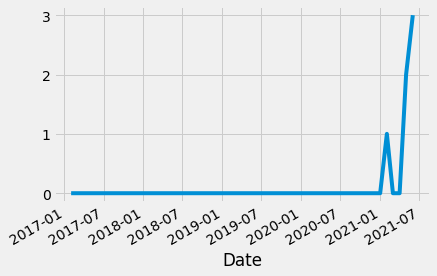

In [137]:
ax = noun_datatable[('size', 'copyright information')].plot()

In [23]:
from itertools import product
from nltk import word_tokenize
from nltk import skipgrams

Skipgrams consider the distance between words, in this case we can creating tuples of words regardless of distance but **without repetition and commutative**.

In [24]:
def word_pairs(text):
    tokens = word_tokenize(text)
    return list(skipgrams(tokens, n=2, k=len(tokens)-1))

In [25]:
noun_df['Noun_pairs'] = noun_df['Nouns'].apply(word_pairs)

In [26]:
noun_df

,Nouns,Date,Noun_pairs
0,blockchain transaction acceleration system,2020-05-01,"[(blockchain, transaction), (blockchain, accel..."
1,transaction,2020-05-01,[]
2,acceleration,2020-05-01,[]
3,transaction,2020-05-01,[]
4,acceleration,2020-05-01,[]
...,...,...,...
28858,tenant system ability,2021-04-01,"[(tenant, system), (tenant, ability), (system,..."
28859,identity end user enrollment verification,2021-04-01,"[(identity, end), (identity, user), (identity,..."
28860,identity knowledge tenant verification,2021-04-01,"[(identity, knowledge), (identity, tenant), (i..."
28861,privacy end user enrollment verification,2021-04-01,"[(privacy, end), (privacy, user), (privacy, en..."


In [27]:
noun_df.reset_index(inplace=True)

In [28]:
noun_df2 = pd.DataFrame(columns=['Noun_pairs', 'Date'])

In [29]:
row_list = []

for i in range(len(data)):
    for pairs in noun_df.loc[i, 'Noun_pairs']:
        date = noun_df.loc[i, 'Date']
        dict1 = {'Date': date, 'Noun_pairs': pairs}
        row_list.append(dict1)

noun_df2 = pd.DataFrame(row_list)

In [30]:
noun_df2

,Date,Noun_pairs
0,2020-05-01,"(blockchain, transaction)"
1,2020-05-01,"(blockchain, acceleration)"
2,2020-05-01,"(blockchain, system)"
3,2020-05-01,"(transaction, acceleration)"
4,2020-05-01,"(transaction, system)"
...,...,...
3319,2020-07-01,"(system, computing)"
3320,2020-07-01,"(system, device)"
3321,2020-07-01,"(computing, device)"
3322,2020-07-01,"(integrity, software)"


In [31]:
noun_df2['Noun_pairs'].tolist()
noun_df3 = pd.DataFrame(noun_df2['Noun_pairs'].tolist(), index=noun_df2.index)

In [32]:
noun_df3

,0,1
0,blockchain,transaction
1,blockchain,acceleration
2,blockchain,system
3,transaction,acceleration
4,transaction,system
...,...,...
3319,system,computing
3320,system,device
3321,computing,device
3322,integrity,software


In [33]:
kg_df = noun_df3.groupby(noun_df3.columns.tolist(),as_index=False).size()

In [34]:
kg_df

,0,1,size
0,acceleration,system,6
1,access,blockchain,1
2,access,challenge,1
3,access,control,4
4,access,device,5
...,...,...,...
1812,world,applications,1
1813,world,blockchain,1
1814,world,identity,1
1815,world,method,1


In [ ]:
import networkx as nx

In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, 0, 1, 
                          edge_attr='size', create_using=nx.MultiDiGraph())

In [ ]:
size = [i['size'] for i in dict(G.edges).values()]

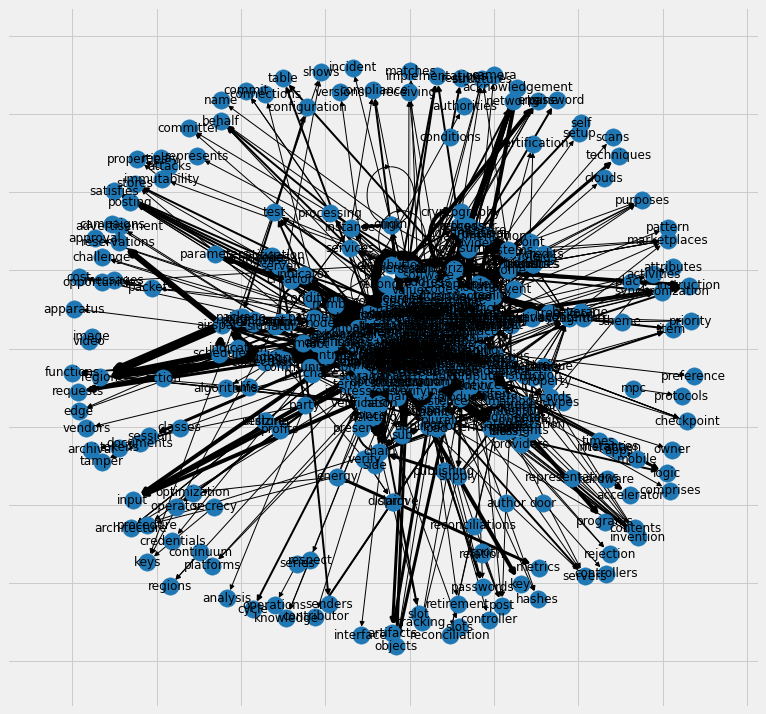

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
# nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
labels = [i for i in dict(G.nodes).keys()]
labels = {i:i for i in dict(G.nodes).keys()}
nx.draw_networkx_nodes(G, pos, label=True)
nx.draw_networkx_edges(G, pos, width=size)
_ = nx.draw_networkx_labels(G, pos, labels)
plt.show()

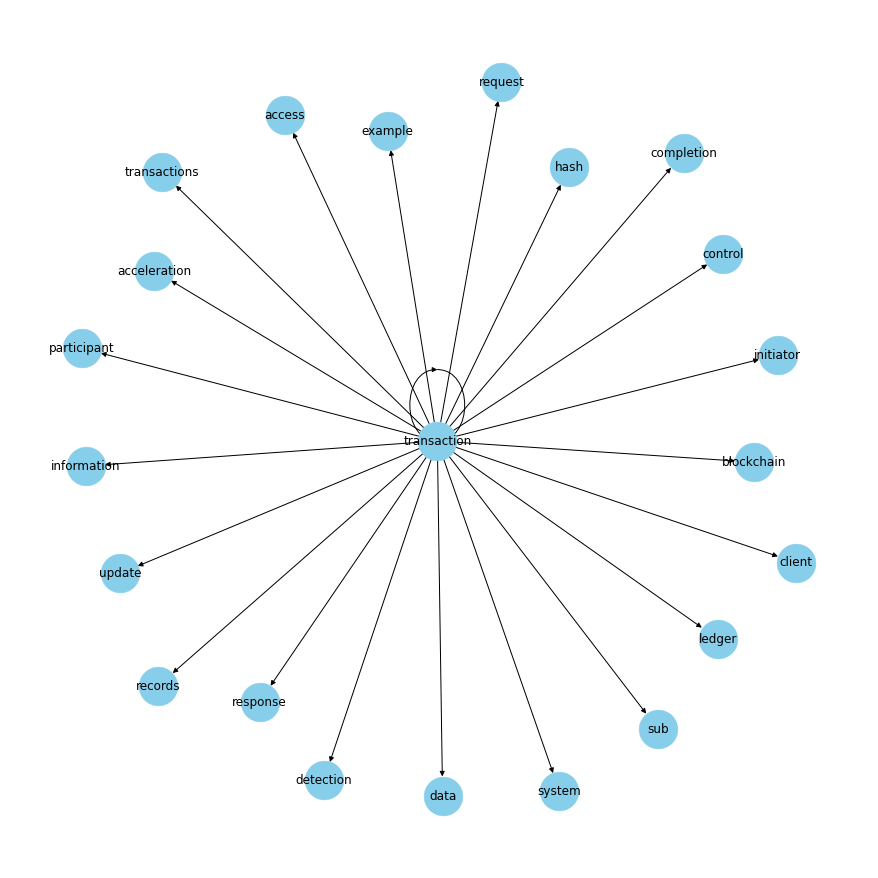

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df[0]=="transaction"], 0, 1, 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()